# Action PixelBytes: Catching Insights in Unified Multimodal Sequences

## Description

Changement de la representation du modele, test d'un token "image, son, texte", mais avec l'ajout d'un vecteur positionnel uniquement pour l'image, le son et le texte. L'idée est de faire une quantification vectorielles des elements et ne donner que la valeurs des centroid "token" et leurs positions 3D. Contrairement au methodes haut niveau (encoder, VAE, etc.) pour construire le vecteur, ici, nous nous restreindrons à des valeurs predifini (palette, bytes) et un simple algorithme K-mean implementé en PyTorch pour la compression. La reconstruction se fera simplement par un Voronoï.


In [2]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from datasets import load_dataset

import torch
import numpy as np
from PIL import Image, ImageSequence

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [4]:
hf_dataset = load_dataset("ffurfaro/PixelBytes-PokemonAll")#['train'].train_test_split(test_size=0.1, seed=42)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/437 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/533 [00:00<?, ? examples/s]

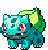

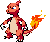

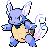

In [5]:
for i in range(0,9,3) :
    display(hf_dataset['train']['image'][i])

In [6]:
gif_image = hf_dataset['train']['image'][4]
frames = torch.stack([torch.tensor(np.array(frame.copy().convert('RGB'))) for frame in ImageSequence.Iterator(gif_image)])
print(np.array(gif_image).shape, frames.shape)

(50, 48, 3) torch.Size([71, 50, 48, 3])


<ipython-input-38-646d7ab541e4>:22: RuntimeWarning: invalid value encountered in cast
  return composite.astype(np.uint8)


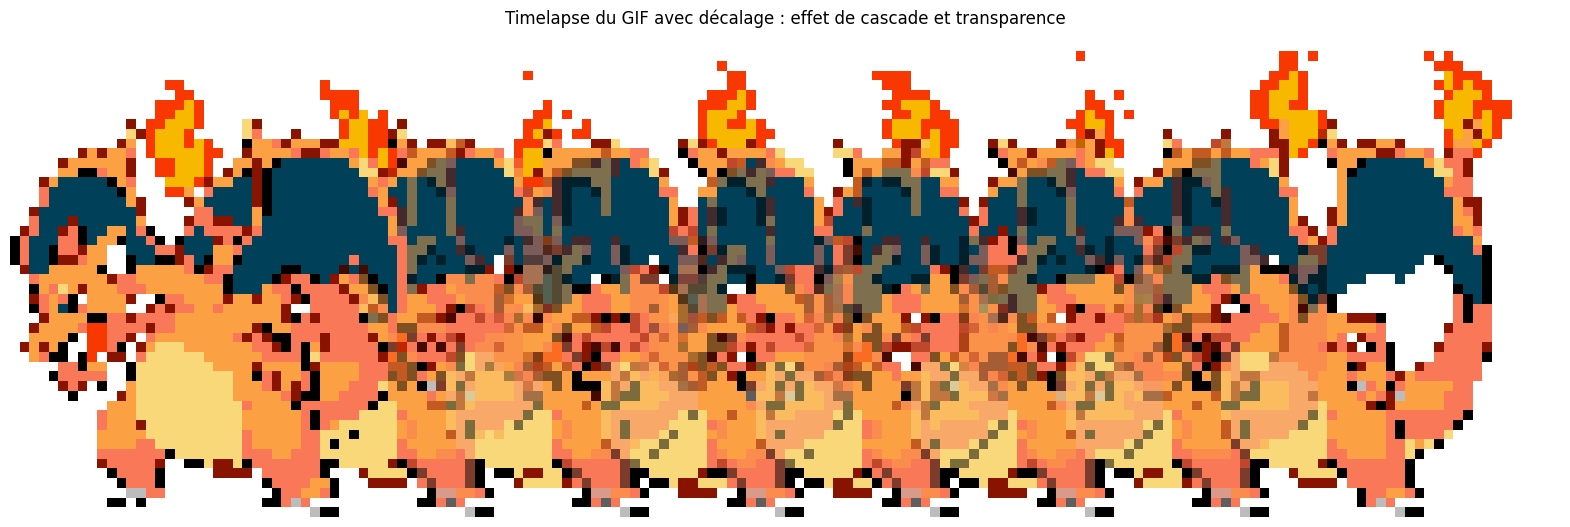

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def create_timelapse(frames, shift=5, background_threshold=240):
    num_frames, h, w, c = frames.shape
    composite = np.zeros((h, w + shift * (num_frames - 1), 4), dtype=float)
    overlap_count = np.zeros(composite.shape[:2], dtype=float)

    is_foreground = np.any(frames <= background_threshold, axis=3)

    for i, frame in enumerate(frames):
        mask = is_foreground[i]
        start_x = i * shift
        composite[:, start_x:start_x+w][mask] += np.dstack((frame, mask * 255))[mask]
        overlap_count[:, start_x:start_x+w] += mask
        if i == 0: first_mask = mask

    composite[:, :, :3] = np.divide(composite[:, :, :3], overlap_count[:, :, np.newaxis], where=overlap_count[:, :, np.newaxis]!=0)
    composite[:, :, 3] = np.minimum(composite[:, :, 3], 255)
    composite[:h, :w, :3][first_mask] = frames[0][first_mask]

    return composite.astype(np.uint8)

frames_np = frames.numpy()[:8]
composite = create_timelapse(frames_np, shift=16)

plt.figure(figsize=(20, 10))
plt.imshow(composite)
plt.axis('off')
plt.title("Timelapse du GIF avec décalage : effet de cascade et transparence")
plt.show()

In [63]:
import numpy as np

def vectorize_frames(frames):
    num_frames, h, w, c = frames.shape
    # Créer un tableau de vecteurs avec les valeurs des pixels et leurs positions
    return np.concatenate([
        frames.reshape(-1, c),  # Valeurs RGB
        np.repeat(np.arange(w), h * num_frames)[:, np.newaxis],  # Coordonnée x
        np.tile(np.repeat(np.arange(h), w), num_frames)[:, np.newaxis],  # Coordonnée y
        np.tile(np.arange(num_frames), h * w)[:, np.newaxis]  # Indice de frame t
    ], axis=1)

# Exemple d'utilisation
frames_np = frames.numpy()[:16]  # Assurez-vous que frames est un tableau NumPy de la forme (num_frames, h, w, c)
vectorized_data = vectorize_frames(frames_np)

# Affichage des 5 premiers vecteurs
print(vectorized_data[:5], vectorized_data.shape)

[[255 255 255   0   0   0]
 [255 255 255   0   0   1]
 [255 255 255   0   0   2]
 [255 255 255   0   0   3]
 [255 255 255   0   0   4]] (38400, 6)


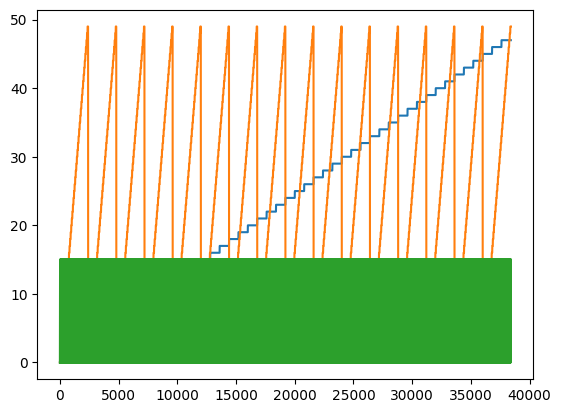

In [64]:
plt.plot(vectorized_data[:, 3:])

In [80]:
from sklearn.cluster import KMeans

# Clustering avec K-means
num_clusters = 2000  # Limiter le nombre de clusters
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(vectorized_data)

# Récupérer les centres des clusters et leurs coordonnées x, y et t
cluster_centers = kmeans.cluster_centers_

# Utiliser uniquement les valeurs RGB pour colorer les centres des clusters
colors = cluster_centers[:, :3] # / 255.0
colors = (colors - colors.min()) / (colors.max() - colors.min())

cluster_centers[:2]

array([[252.        , 160.        ,  68.        ,  46.18518519,
         31.62962963,   3.22222222],
       [255.        , 255.        , 255.        ,  25.        ,
         22.14285714,  10.57142857]])

In [81]:
cluster_centers.astype(int)

array([[252, 160,  68,  46,  31,   3],
       [255, 254, 254,  25,  22,  10],
       [  0,  63,  87,  22,  22,  13],
       ...,
       [136,  20,   0,  45,  23,   1],
       [  0,  63,  87,  24,  14,  13],
       [252, 160,  67,  43,  26,  14]])

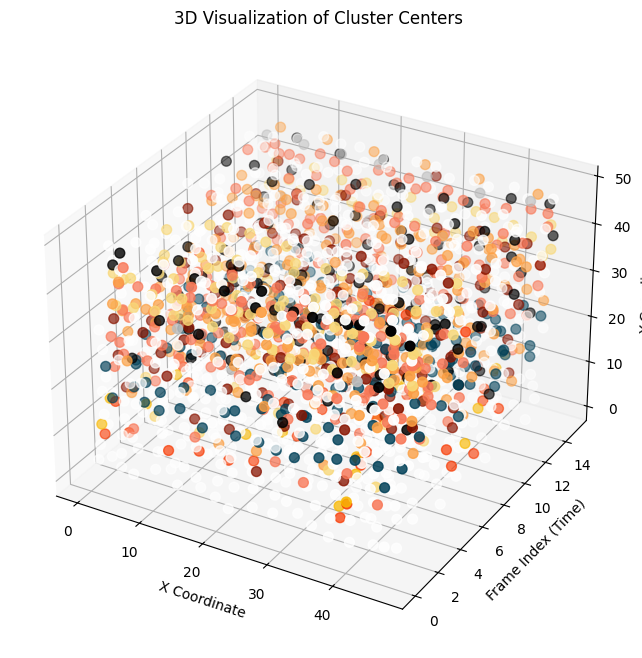

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Visualisation des centres des clusters en 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot avec couleurs basées sur les valeurs RGB des centres des clusters
ax.scatter(cluster_centers[:, 3], cluster_centers[:, 5], cluster_centers[:, 4], c=colors, s=50)  # Couleur par valeur RGB

ax.set_xlabel('X Coordinate')
ax.set_zlabel('Y Coordinate')
ax.set_ylabel('Frame Index (Time)')
ax.set_title('3D Visualization of Cluster Centers')

plt.show()

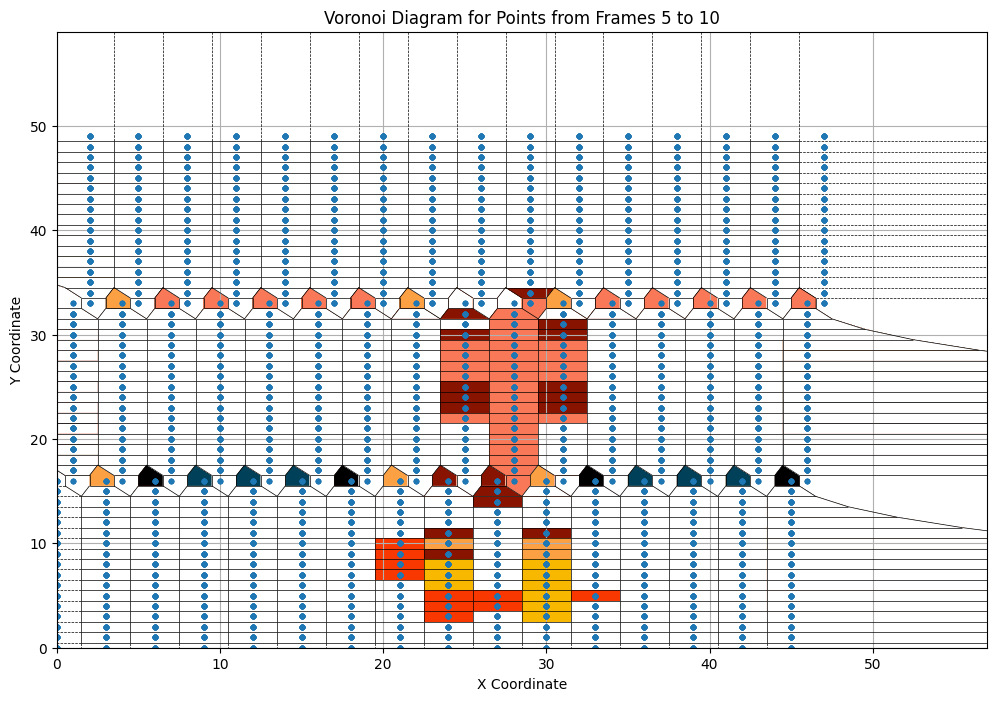

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon

# Définir l'intervalle de temps souhaité (par exemple, frames 5 à 10)
start_frame = 5
end_frame = 10

# Filtrer les données pour l'intervalle de temps donné
time_filtered_data = vectorized_data[(vectorized_data[:, 5] >= start_frame) & (vectorized_data[:, 5] < end_frame)]

# Projeter sur le plan XY (X et Y)
x_coords = time_filtered_data[:, 3]  # Coordonnées X
y_coords = time_filtered_data[:, 4]  # Coordonnées Y

# Créer le diagramme de Voronoi
points = np.column_stack((x_coords, y_coords))
vor = Voronoi(points)

# Visualisation du diagramme de Voronoi avec remplissage des cellules
fig, ax = plt.subplots(figsize=(12, 8))

# Remplir chaque cellule du diagramme de Voronoi avec la couleur RGB correspondante
for i in range(len(points)):
    # Récupérer les indices des vertices pour chaque cellule de Voronoi
    region_index = vor.point_region[i]
    vertices = vor.regions[region_index]

    if -1 not in vertices:  # Ignorer les régions infinies
        polygon = Polygon([vor.vertices[v] for v in vertices], closed=True)
        ax.add_patch(polygon)
        color = time_filtered_data[i, :3] / 255.0  # Normaliser la couleur RGB pour Matplotlib
        polygon.set_facecolor(color)  # Remplir avec la couleur

# Ajouter les lignes de Voronoi
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=0.5)

# Ajouter les points originaux au graphique
ax.scatter(x_coords, y_coords, c='black', s=5)  # Points originaux en noir

plt.xlim([0, max(x_coords) + 10])  # Ajuster les limites selon vos données
plt.ylim([0, max(y_coords) + 10])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Voronoi Diagram for Points from Frames {start_frame} to {end_frame}')
plt.grid(True)
plt.show()


In [7]:
N, C, H, W = frames.shape
X = frames.view(N, C, -1).permute(0, 2, 1).reshape(-1, C).float()

# Implémentation du K-means
def kmeans(X, n_clusters, max_iters=100):
    # Initialisation aléatoire des centroids
    centroids = X[torch.randperm(X.shape[0])[:n_clusters]] ## mettre uniforme ici

    for _ in range(max_iters):
        # Calcul des distances
        distances = torch.cdist(X, centroids)

        # Attribution des clusters
        labels = torch.argmin(distances, dim=1)

        # Mise à jour des centroids
        new_centroids = torch.stack([X[labels == k].mean(dim=0) for k in range(n_clusters)])

        # Vérification de la convergence
        if torch.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return labels, centroids

# Application du clustering
n_clusters = 5  # Nombre de clusters souhaité
labels, centroids = kmeans(X, n_clusters)

# Reconstruction de l'image clusterisée
clustered_frames = centroids[labels].view(N, H, W, C).permute(0, 3, 1, 2)

In [ ]:
# Réorganisation des dimensions
clustered_frames = clustered_frames.permute(0, 2, 3, 1)

# Fonction pour initialiser l'animation
def init():
    return plt.imshow(clustered_frames[0].cpu().numpy())

# Fonction pour mettre à jour chaque frame
def update(frame):
    plt.clf()
    return plt.imshow(clustered_frames[frame].cpu().numpy())

# Création de l'animation
fig = plt.figure(figsize=(8, 8))
anim = FuncAnimation(fig, update, frames=range(N), init_func=init, interval=100)

# Affichage de l'animation
HTML(anim.to_jshtml())